In [ ]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms

mean, std = 0.1307, 0.3081

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

## Common setup

In [ ]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [ ]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [6]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

Train: [0/60000 (0%)]	Loss: 2.397717	Accuracy: 11.328125
Train: [12800/60000 (21%)]	Loss: 2.853554	Accuracy: 12.147671568627452
Train: [25600/60000 (43%)]	Loss: 1.997199	Accuracy: 19.02459777227723
Train: [38400/60000 (64%)]	Loss: 1.434532	Accuracy: 28.3216059602649
Train: [51200/60000 (85%)]	Loss: 0.888718	Accuracy: 38.62134639303483
Epoch: 1/20. Train set: Average loss: 1.6188	Accuracy: 45.24333333333333
Epoch: 1/20. Validation set: Average loss: 0.5106	Accuracy: 88.83
Train: [0/60000 (0%)]	Loss: 0.550414	Accuracy: 89.84375
Train: [12800/60000 (21%)]	Loss: 0.448207	Accuracy: 90.4718137254902
Train: [25600/60000 (43%)]	Loss: 0.354107	Accuracy: 91.55708539603961
Train: [38400/60000 (64%)]	Loss: 0.245407	Accuracy: 92.68677566225166
Train: [51200/60000 (85%)]	Loss: 0.248621	Accuracy: 93.19029850746269
Epoch: 2/20. Train set: Average loss: 0.3095	Accuracy: 93.51833333333333
Epoch: 2/20. Validation set: Average loss: 0.2011	Accuracy: 95.26
Train: [0/60000 (0%)]	Loss: 0.312263	Accuracy: 92.

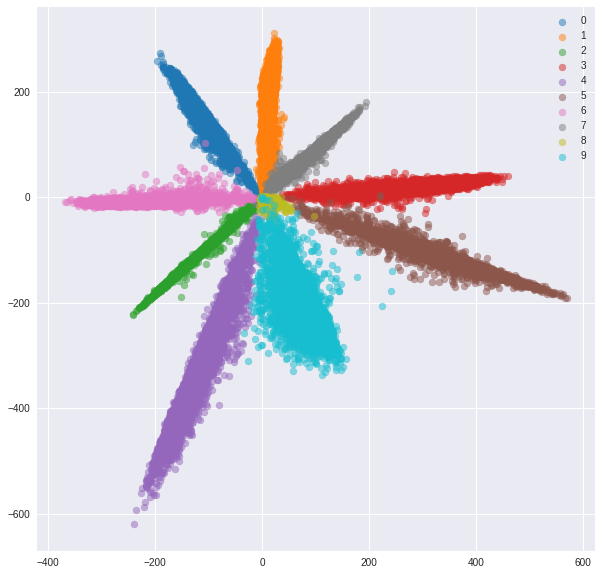

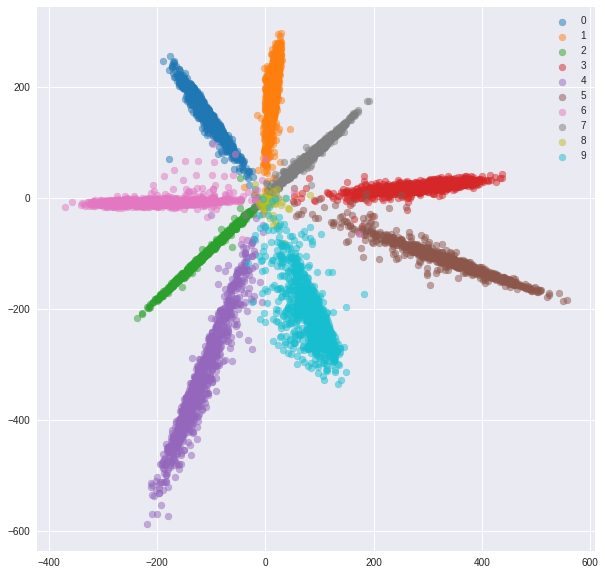

In [7]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [ ]:
# Set up data loaders
from datasets import SiameseMNIST

siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [9]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.238478
Train: [12800/60000 (21%)]	Loss: 0.067090
Train: [25600/60000 (43%)]	Loss: 0.039554
Train: [38400/60000 (64%)]	Loss: 0.029093
Train: [51200/60000 (85%)]	Loss: 0.024434
Epoch: 1/20. Train set: Average loss: 0.0376
Epoch: 1/20. Validation set: Average loss: 0.0179
Train: [0/60000 (0%)]	Loss: 0.023541
Train: [12800/60000 (21%)]	Loss: 0.017051
Train: [25600/60000 (43%)]	Loss: 0.015608
Train: [38400/60000 (64%)]	Loss: 0.013117
Train: [51200/60000 (85%)]	Loss: 0.012238
Epoch: 2/20. Train set: Average loss: 0.0142
Epoch: 2/20. Validation set: Average loss: 0.0119
Train: [0/60000 (0%)]	Loss: 0.009957
Train: [12800/60000 (21%)]	Loss: 0.008556
Train: [25600/60000 (43%)]	Loss: 0.009106
Train: [38400/60000 (64%)]	Loss: 0.009774
Train: [51200/60000 (85%)]	Loss: 0.008238
Epoch: 3/20. Train set: Average loss: 0.0088
Epoch: 3/20. Validation set: Average loss: 0.0100
Train: [0/60000 (0%)]	Loss: 0.007532
Train: [12800/60000 (21%)]	Loss: 0.006329
Train: [25600/60000 (

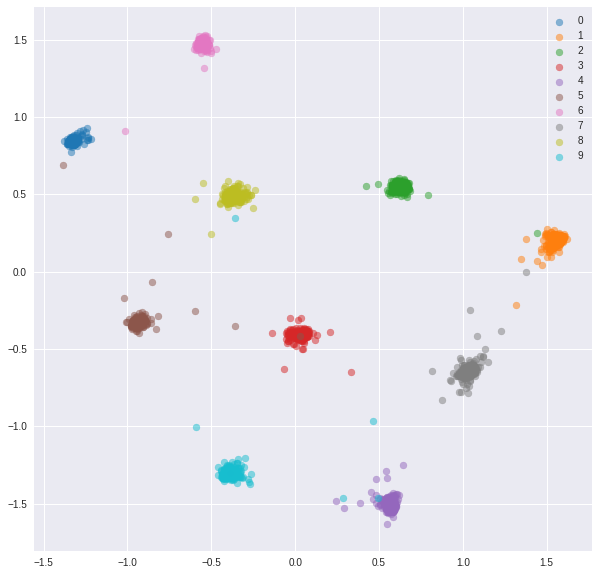

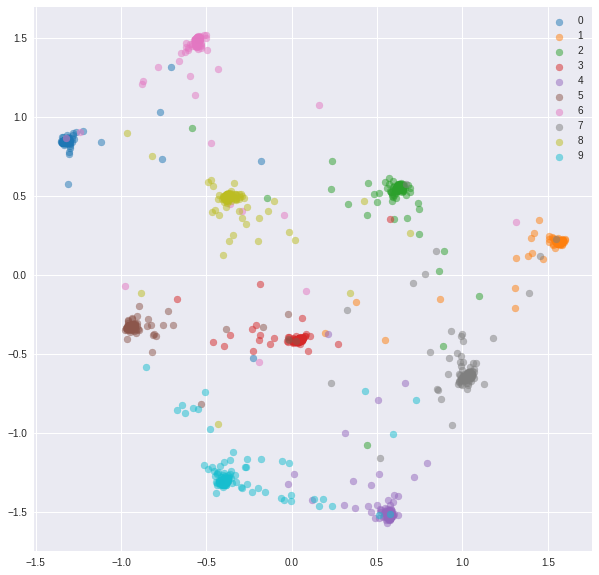

In [10]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [ ]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [12]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.999480
Train: [12800/60000 (21%)]	Loss: 0.258000
Train: [25600/60000 (43%)]	Loss: 0.125140
Train: [38400/60000 (64%)]	Loss: 0.091101
Train: [51200/60000 (85%)]	Loss: 0.076680
Epoch: 1/20. Train set: Average loss: 0.1290
Epoch: 1/20. Validation set: Average loss: 0.0419
Train: [0/60000 (0%)]	Loss: 0.066908
Train: [12800/60000 (21%)]	Loss: 0.048238
Train: [25600/60000 (43%)]	Loss: 0.049542
Train: [38400/60000 (64%)]	Loss: 0.046033
Train: [51200/60000 (85%)]	Loss: 0.041020
Epoch: 2/20. Train set: Average loss: 0.0458
Epoch: 2/20. Validation set: Average loss: 0.0393
Train: [0/60000 (0%)]	Loss: 0.000000
Train: [12800/60000 (21%)]	Loss: 0.041703
Train: [25600/60000 (43%)]	Loss: 0.034695
Train: [38400/60000 (64%)]	Loss: 0.027559
Train: [51200/60000 (85%)]	Loss: 0.033024
Epoch: 3/20. Train set: Average loss: 0.0335
Epoch: 3/20. Validation set: Average loss: 0.0273
Train: [0/60000 (0%)]	Loss: 0.067078
Train: [12800/60000 (21%)]	Loss: 0.025000
Train: [25600/60000 (

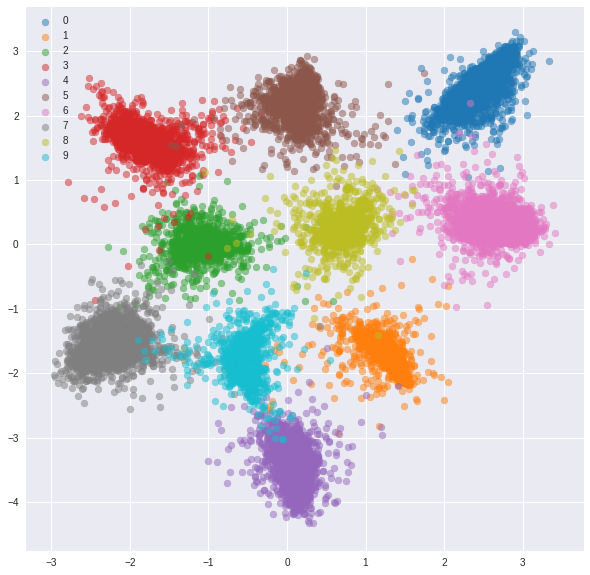

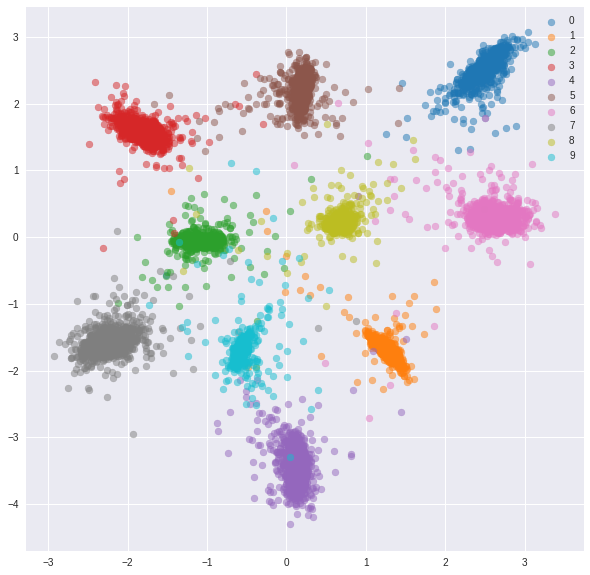

In [13]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [15]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.490332
Train: [12500/60000 (21%)]	Loss: 0.319152
Train: [25000/60000 (42%)]	Loss: 0.154429
Train: [37500/60000 (62%)]	Loss: 0.100240
Train: [50000/60000 (83%)]	Loss: 0.071847
Epoch: 1/20. Train set: Average loss: 0.1467
Epoch: 1/20. Validation set: Average loss: 0.0538
Train: [0/60000 (0%)]	Loss: 0.036259
Train: [12500/60000 (21%)]	Loss: 0.054319
Train: [25000/60000 (42%)]	Loss: 0.044727
Train: [37500/60000 (62%)]	Loss: 0.043608
Train: [50000/60000 (83%)]	Loss: 0.038870
Epoch: 2/20. Train set: Average loss: 0.0433
Epoch: 2/20. Validation set: Average loss: 0.0313
Train: [0/60000 (0%)]	Loss: 0.026528
Train: [12500/60000 (21%)]	Loss: 0.024754
Train: [25000/60000 (42%)]	Loss: 0.029278
Train: [37500/60000 (62%)]	Loss: 0.029869
Train: [50000/60000 (83%)]	Loss: 0.027097
Epoch: 3/20. Train set: Average loss: 0.0272
Epoch: 3/20. Validation set: Average loss: 0.0261
Train: [0/60000 (0%)]	Loss: 0.026527
Train: [12500/60000 (21%)]	Loss: 0.019682
Train: [25000/60000 (

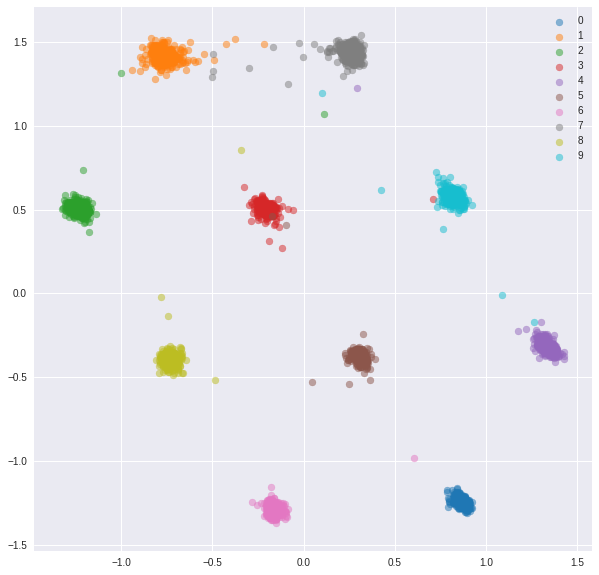

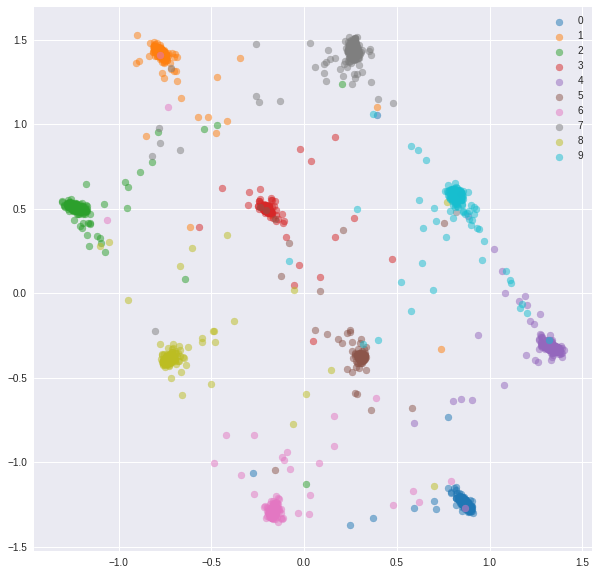

In [16]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [18]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.999403	Average nonzero triplets: 3000.0
Train: [12500/60000 (21%)]	Loss: 0.984588	Average nonzero triplets: 2583.392156862745
Train: [25000/60000 (42%)]	Loss: 0.969877	Average nonzero triplets: 2306.5940594059407
Train: [37500/60000 (62%)]	Loss: 0.961404	Average nonzero triplets: 2077.754966887417
Train: [50000/60000 (83%)]	Loss: 0.985315	Average nonzero triplets: 1877.3333333333333
Epoch: 1/20. Train set: Average loss: 0.9779	Average nonzero triplets: 1763.6192468619247
Epoch: 1/20. Validation set: Average loss: 0.8653	Average nonzero triplets: 1125.3076923076924
Train: [0/60000 (0%)]	Loss: 0.578054	Average nonzero triplets: 638.0
Train: [12500/60000 (21%)]	Loss: 1.009860	Average nonzero triplets: 952.6078431372549
Train: [25000/60000 (42%)]	Loss: 1.025786	Average nonzero triplets: 896.5346534653465
Train: [37500/60000 (62%)]	Loss: 1.044503	Average nonzero triplets: 889.6688741721854
Train: [50000/60000 (83%)]	Loss: 1.029733	Average nonzero triplets: 861.

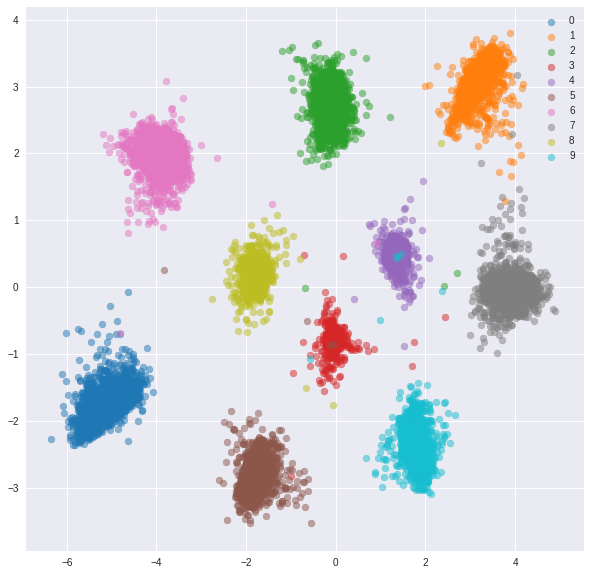

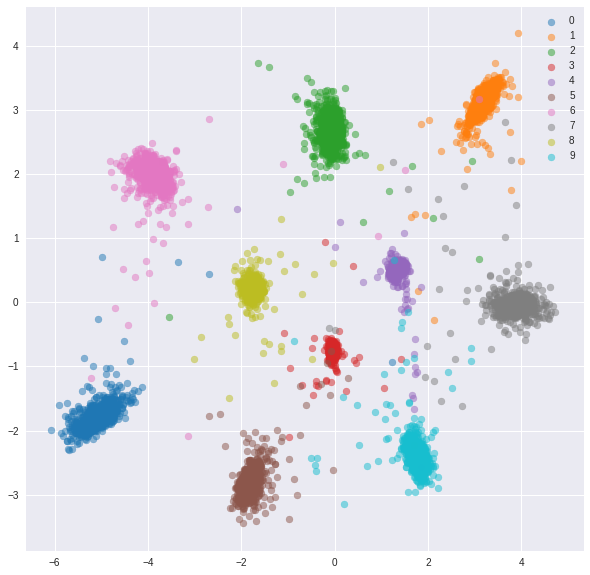

In [19]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

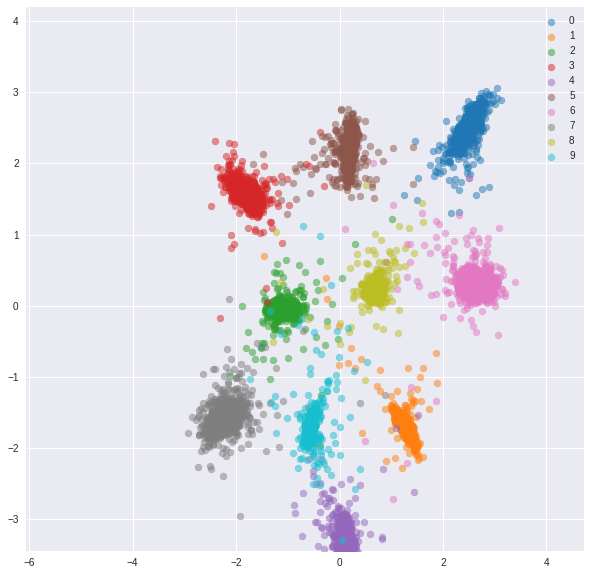

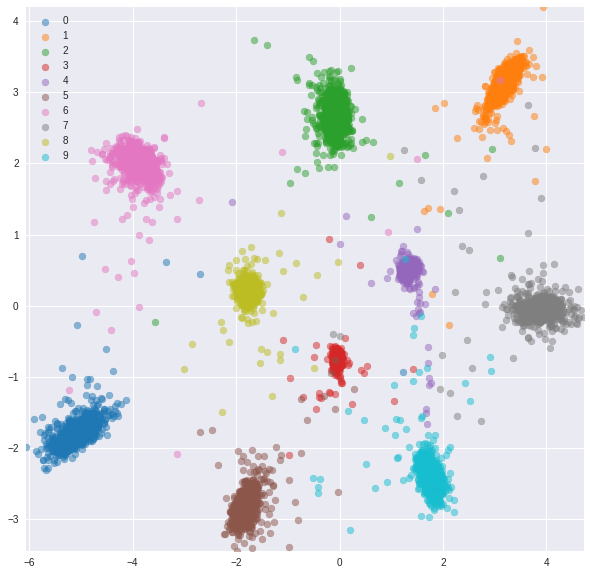

In [20]:
# display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

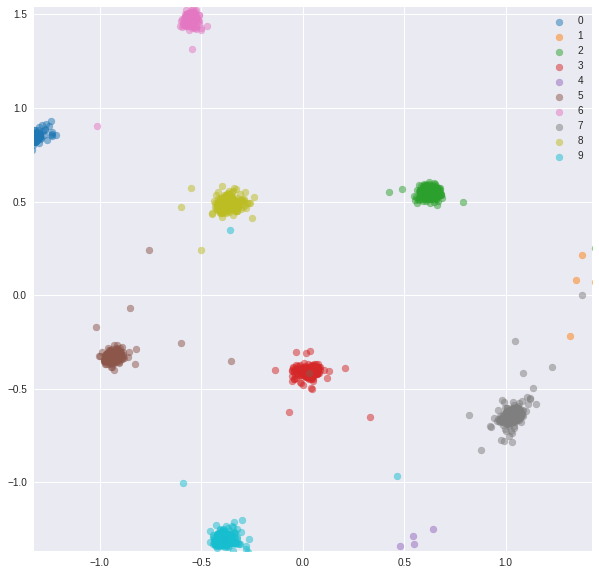

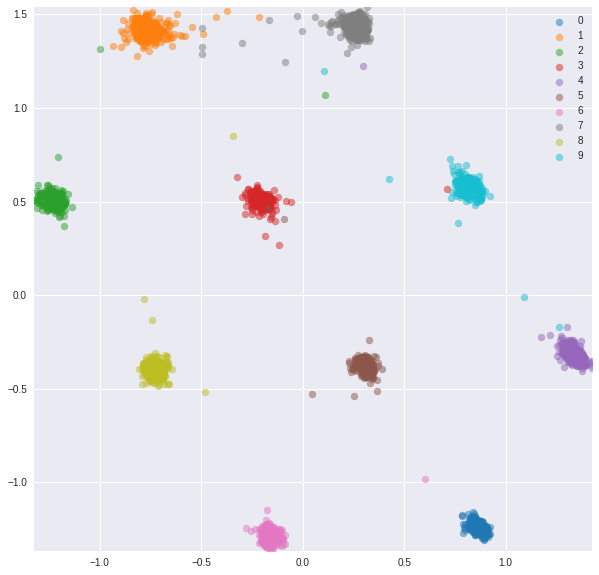

In [21]:
x_lim = (np.min(train_embeddings_ocl[:,0]), np.max(train_embeddings_ocl[:,0]))
y_lim = (np.min(train_embeddings_ocl[:,1]), np.max(train_embeddings_ocl[:,1]))
plot_embeddings(train_embeddings_cl, train_labels_cl, x_lim, y_lim)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, x_lim, y_lim)